# Image registration of an EBSD data set to a BSE image

Håkon Wiik Ånes (hakon.w.anes@ntnu.no)

In [1]:
# Switch to interactive Matplotlib backend (e.g. qt5) for control point determination
%matplotlib inline

from datetime import date
import importlib_metadata
import os

from dask.diagnostics import ProgressBar
import dask
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import morphops
import numpy as np
from orix import io as oio
from orix.crystal_map import CrystalMap
from orix.quaternion import Rotation
import skimage.color as skc
import skimage.exposure as ske
import skimage.transform as skt
import skimage.util as sku
from tqdm import trange, tqdm


# Directories
dset_no = 1
dir_data = "/home/hakon/phd/data/p/prover/300c"
dir_sample = os.path.join(dir_data, str(dset_no))
dir_bse = os.path.join(dir_sample, "bse")
dir_imreg = os.path.join(dir_sample, "imreg")
dir_kp = os.path.join(dir_sample, "kp")
dir_suppl = "/home/hakon/phd/artikler_abstract/202104_correlating_ebsd_bse/latex/supplementary/fig"

# Data set specific parameters
out_shapes = {1: (1000, 1000), 2: (900, 820), 3: (1050, 950)}

# Matplotlib
plt.rcParams.update({"font.size": 12, "figure.dpi": 150})
savefig_kw = dict(bbox_inches="tight", pad_inches=0, transparent=True)

print("Run date: ", date.today())
print("\nSoftware versions\n-----------------")
for pkg in [
    "dask",
    "matplotlib",
    "morphops",
    "numpy",
    "orix",
    "scikit-image",
    "tqdm"
]:
    if pkg == "numpy":
        ver = np.__version__
    else:
        ver = importlib_metadata.version(pkg)
    print(pkg, ":", ver)

Run date:  2022-07-24

Software versions
-----------------
dask : 2022.6.0
matplotlib : 3.5.2
morphops : 0.1.13
numpy : 1.22.4
orix : 0.9.0.post0
scikit-image : 0.19.3
tqdm : 4.64.0


Step sizes

In [2]:
step_size = dict(ebsd=100, bse=1 / 38.5e-3)

New BSE scale so that the particle map produced from the upscaled BSE image can be binned by an integer factor

In [3]:
x_bin = int(np.ceil(step_size["ebsd"] / step_size["bse"]))
upscale_factor = x_bin * (step_size["bse"] / step_size["ebsd"])

## 1. Manually identify control points

EBSD map (sensed image)

In [4]:
ebsd = plt.imread(os.path.join(dir_kp, "maps_mean_q1_q99.png"))
ebsd = skc.rgb2gray(ebsd[..., :3])

BSE image (reference image)

In [5]:
bse = plt.imread(os.path.join(dir_bse, "4500x_cropped2_fused_cropped.png"))
bse = skc.rgb2gray(bse[..., :3])

Identify coordinates (x, y) and (X, Y) of corresponding control points and write
them to a text file

In [6]:
#fig, (ax0, ax1) = plt.subplots(ncols=2)
#ax0.imshow(ebsd, cmap="gray")
#ax1.imshow(bse, cmap="gray");

Load identified control points

In [7]:
cpx_ebsd, cpy_ebsd, cpx_bse, cpy_bse = np.loadtxt(
    os.path.join(dir_imreg, "cps_300c_cropped2_fused_cropped.csv"),
    skiprows=1,
    delimiter=",",
    unpack=True,
)
n_cps = cpx_ebsd.size
cp_ebsd = np.column_stack([cpy_ebsd, cpx_ebsd])
cp_bse = np.column_stack([cpy_bse, cpx_bse])

## 2. Scale out control point coordinates in

In [8]:
cp_bse_scaled = cp_bse / (step_size["ebsd"] / step_size["bse"])

## 3. Correct source image using the thin plate spline transformation function

Get inverse map (input coordinates in the output image) using `morphops`. We use `dask` to wrap calls to `morphops` to keep memory use low.

In [9]:
# Output shape of corrected EBSD map
out_shape = out_shapes[dset_no]
out_size = int(np.prod(out_shape))

# 2D indices (flattened) for each point in the output map
rc_out = np.indices(out_shape, dtype=float).reshape((2, -1)).T

# Obtain inverse mapping one chunk at a time to reduce memory use. This is done
# by first accumulating a list of delayed computations...
delayed_list = []
n_chunks = 100
chunk_size = int(np.ceil(out_size / n_chunks))
for idx in range(0, n_chunks * chunk_size, chunk_size):
    rc_chunk = rc_out[idx:idx + chunk_size]
    rc_in_part = dask.delayed(morphops.tps_warp)(X=cp_bse_scaled, Y=cp_ebsd, pts=rc_chunk)
    delayed_list.append(rc_in_part)

# ... and then computing the inverse mappings
with ProgressBar():
    rc_in_parts = dask.compute(*delayed_list)
rc_in = np.row_stack(rc_in_parts)

[########################################] | 100% Completed |  2.5s


Check coordinate shifts

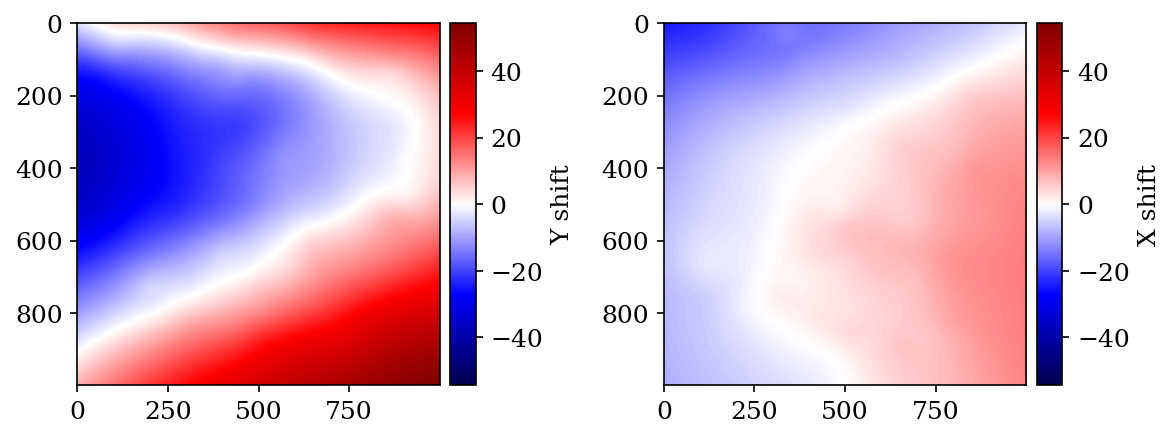

In [10]:
rc_shift = rc_in - rc_out
rc_center = rc_shift - rc_shift.mean(axis=0)

labels = ("Y shift", "X shift")
v_extent = max(abs(rc_center.min()), abs(rc_center.max()))
imshow_kwds = dict(vmin=-v_extent, vmax=v_extent, cmap="seismic")

fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
for i, a in enumerate(ax):
    im = a.imshow(rc_center[:, i].reshape(out_shape), **imshow_kwds)
    ax_divider = make_axes_locatable(a)
    fig.colorbar(im, cax=ax_divider.append_axes("right", size="7%", pad="3%"), label=labels[i])
fig.tight_layout()
fig.savefig(os.path.join(dir_imreg, "rc_shift.png"), **savefig_kw)

In [11]:
def get_mapping_arrays(rc_in, in_shape, out_shape):
    """Get 1D indices of corresponding points in input and output
    arrays.
    
    Parameters
    ----------
    rc_in : numpy.ndarray
    in_shape : tuple
    out_shape : tuple
    
    Returns
    -------
    rc_in_1d : numpy.ndarray
    rc_in_2d : tuple of numpy.ndarray
    rc_out_1d : numpy.ndarray
    rc_out_2d : tuple of numpy.ndarray
    """
    # Round exact input coordinates to nearest neighbour coordinates
    rc_in_int = np.round(rc_in).astype(int)

    # Set up output coordinate array
    rc_out = np.indices(out_shape).reshape((2, -1)).T
    
    # Remove coordinates outside input map in both arrays
    is_outside = np.logical_or((rc_in_int < 0).any(axis=1), (rc_in_int >= np.array(in_shape)).any(axis=1))
    is_outside_idx = np.where(is_outside)[0]
    rc_in_int = np.delete(rc_in_int, is_outside_idx, axis=0)
    rc_out = np.delete(rc_out, is_outside_idx, axis=0)
    
    # Get 1D indices
    rc_in_1d = np.ravel_multi_index(rc_in_int.T, in_shape)
    rc_out_1d = np.ravel_multi_index(rc_out.T, out_shape)

    # 2D coordinate arrays
    rc_in_2d = np.unravel_index(rc_in_1d, in_shape)
    rc_out_2d = np.unravel_index(rc_out_1d, out_shape)
    
    return rc_in_1d, rc_in_2d, rc_out_1d, rc_out_2d


def map_in_image(in_image, out_shape, rc_in_2d, rc_out_2d):
    """Map sensed (in) image from sensed coordinates to
    reference coordinates.
    
    Parameters
    ----------
    in_image : numpy.ndarray
    out_shape : tuple
    rc_in_2d : tuple of numpy.ndarray
    rc_out_2d : tuple of numpy.ndarray
    
    Returns
    -------
    out_image : numpy.ndarray
    """
    out_image = np.zeros(out_shape, dtype=in_image.dtype)
    out_image[rc_out_2d] = in_image[rc_in_2d]
    return out_image

In [12]:
rc_in_1d, rc_in_2d, rc_out_1d, rc_out_2d = get_mapping_arrays(
    rc_in=rc_in, in_shape=ebsd.shape, out_shape=out_shape
)

Check mapping of EBSD intensity map

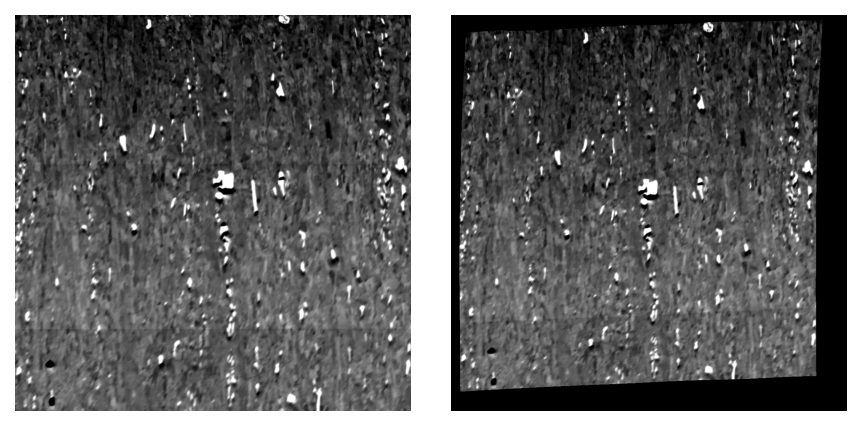

In [13]:
ebsd_correct = map_in_image(ebsd, out_shape, rc_in_2d, rc_out_2d)

fig, ax = plt.subplots(figsize=(6, 3), ncols=2)
ax[0].imshow(ebsd, cmap="gray")
ax[1].imshow(ebsd_correct, cmap="gray")
for a in ax:
    a.axis("off")
fig.tight_layout()

In [14]:
mask = np.zeros(out_shape, dtype=bool)
mask[rc_out_2d] = True

plt.imsave(os.path.join(dir_imreg, "ebsd_correct.png"), ebsd_correct, cmap="gray")
np.save(os.path.join(dir_imreg, "mask_ebsd_correct"), mask)

Check overlap of EBSD map and BSE image

In [15]:
mask = np.zeros(out_shape, dtype=bool)
mask[rc_out_2d] = True

scale = step_size["ebsd"] / step_size["bse"]
mask2 = skt.rescale(mask, scale).astype(bool)
ebsd_correct2 = skt.rescale(ebsd_correct, scale)
mask2 = mask2[:bse.shape[0], :bse.shape[1]]
ebsd_correct3 = ebsd_correct2[:bse.shape[0], :bse.shape[1]]

bse2 = bse.copy()
bse2[~mask2] = 0

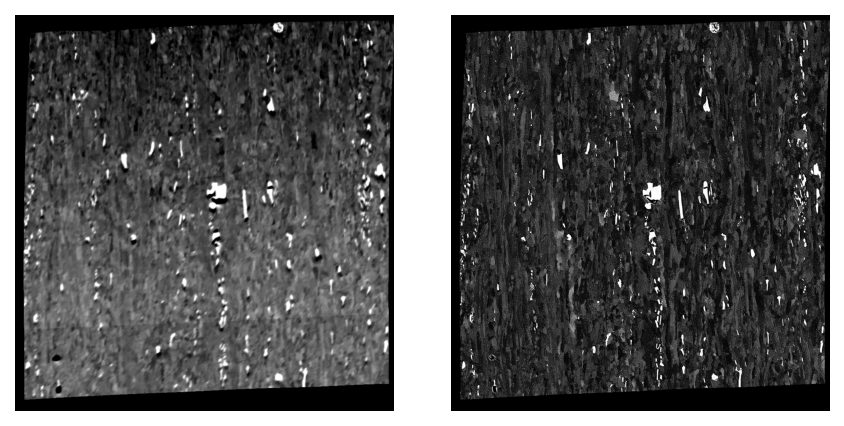

In [16]:
fig, ax = plt.subplots(figsize=(6, 3), ncols=2, sharex=True, sharey=True)
ax[0].imshow(ebsd_correct3, cmap="gray")
ax[1].imshow(bse2, cmap="gray")
for a in ax:
    a.axis("off")
fig.tight_layout()

Check similarity of corrected EBSD map and BSE image

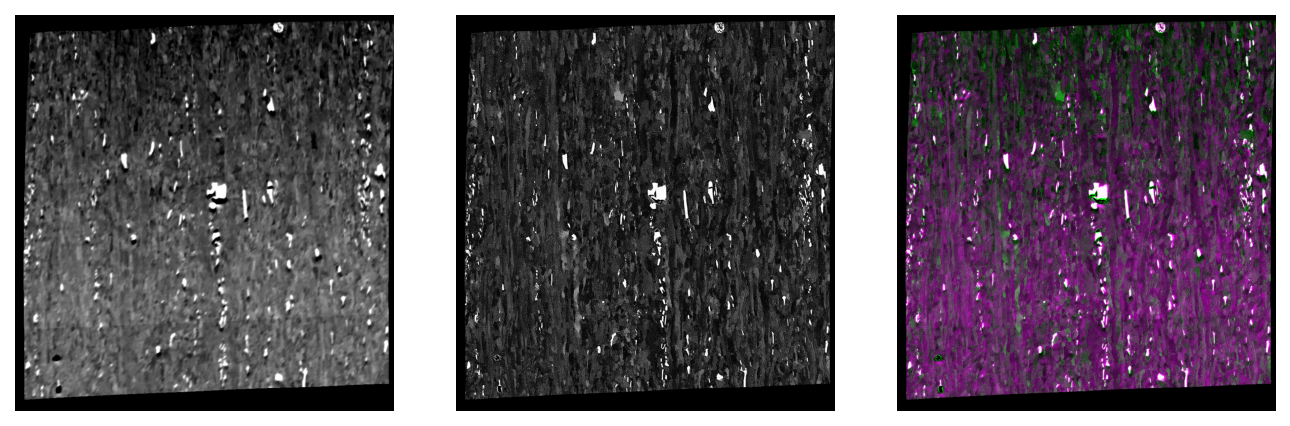

In [17]:
ebsd_correct4 = ske.rescale_intensity(ebsd_correct3, out_range=(0, 1))
bse3 = ske.rescale_intensity(bse2, out_range=(0, 1))
reg_im = np.stack((ebsd_correct4, bse3, ebsd_correct4), axis=2)

fig, ax = plt.subplots(figsize=(9, 3), ncols=3, sharex=True, sharey=True)
ax[0].imshow(ebsd_correct4, cmap="gray")
ax[1].imshow(bse3, cmap="gray")
ax[2].imshow(reg_im)
for a in ax:
    a.axis("off")
fig.tight_layout()

In [18]:
# With padding
plt.imsave(os.path.join(dir_imreg, "reg_ebsd.png"), ebsd_correct4, cmap="gray")
plt.imsave(os.path.join(dir_imreg, "reg_bse.png"), bse3, cmap="gray")
plt.imsave(os.path.join(dir_imreg, "reg_rgb.png"), reg_im)

In [19]:
# Save images also without padding
rc_out_2d_scale = np.column_stack(rc_out_2d) * scale
r_start, c_start = np.floor(rc_out_2d_scale.min(axis=0)).astype(int)
r_end, c_end = np.ceil(rc_out_2d_scale.max(axis=0)).astype(int)
sl = (slice(r_start, r_end), slice(c_start, c_end))
plt.imsave(os.path.join(dir_imreg, "reg_ebsd_no_padding.png"), ebsd_correct4[sl], cmap="gray")
plt.imsave(os.path.join(dir_imreg, "reg_bse_no_padding.png"), bse3[sl], cmap="gray")
plt.imsave(os.path.join(dir_imreg, "reg_rgb_no_padding.png"), reg_im[sl])

## 4. Upsample source image before particle detection

In [20]:
bse4 = skt.rescale(bse, upscale_factor)
plt.imsave(os.path.join(dir_imreg, "bse_rescaled.png"), bse4, cmap="gray")

## 5. Detect particles in upscaled source image

Done in notebook `particle_detection.ipynb`.

## 6. Bin particle map and extract only ROI

Load binary particle map

In [21]:
labels = np.load(os.path.join(dir_imreg, "bse_labels_filled_filtered.npy"))

Slice binary particle map to enable integer binning

In [22]:
row_labels, col_labels = labels.shape
row_new = row_labels - (row_labels % x_bin)
col_new = col_labels - (col_labels % x_bin)
labels2 = labels[:row_new, :col_new]

Separate the map into blocks of equal size, e.g. (4, 4), which are binned using
a custom function

In [23]:
view = sku.view_as_blocks(labels2, block_shape=(x_bin, x_bin))

Bin by counting the number of particles within each block and the number of
unbinned pixels that are particles. This property is important because within
each block of size (4, 4), a particle of one pixel and 16 pixels must of course
be assigned different sizes in the final analysis.

In [24]:
def count_particles(block):
    unique_labels, unique_counts = np.unique(block, return_counts=True)
    particle_labels = unique_labels > 0
    return np.count_nonzero(particle_labels), unique_counts[particle_labels]


n_particles = np.zeros(view.shape[:2], dtype=int)
n_pixels_list = np.zeros(view.shape[:2], dtype=object)
for idx in tqdm(np.ndindex(view.shape[:-2]), total=np.prod(view.shape[:2])):
    n_particles_i, n_pixels_i = count_particles(view[idx])
    n_particles[idx] = n_particles_i
    n_pixels_list[idx] = n_pixels_i

100%|█████████████████████████████████████████████████████████| 915365/915365 [00:19<00:00, 45987.62it/s]


Calculate number of particle pixels within each binned pixel

In [25]:
particle_mask = n_particles != 0
n_pixels = np.zeros(n_particles.shape, dtype=float)
for r, c in zip(*np.where(particle_mask)):
    n_pixels[r, c] = n_pixels_list[r, c].sum()

Make particle map of equal size to new EBSD data

In [26]:
n_particles_roi = np.zeros(out_shape, dtype=int)
n_pixels_roi = np.zeros(out_shape)
nr_part, nc_part = n_particles.shape
n_particles_roi[:nr_part, :nc_part] = n_particles
n_pixels_roi[:nr_part, :nc_part] = n_pixels

# Mask to ROI only
mask = np.zeros(out_shape, dtype=bool)
mask[rc_out_2d] = True
n_particles_roi[~mask] = 0
n_pixels_roi[~mask] = 0

Check overlap

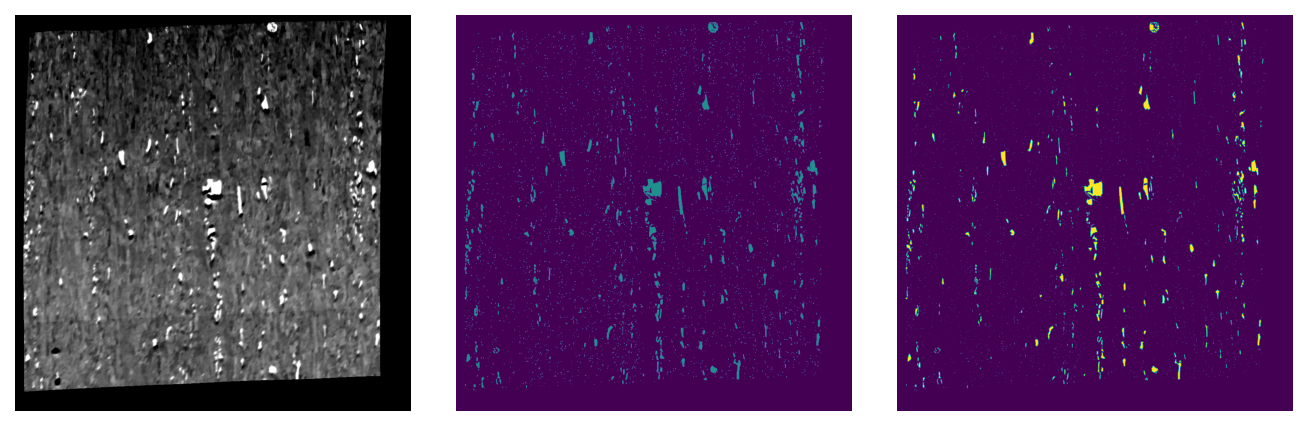

In [27]:
fig, ax = plt.subplots(figsize=(9, 3), ncols=3, sharex=True, sharey=True)
ax[0].imshow(ebsd_correct, cmap="gray")
ax[1].imshow(n_particles_roi)
ax[2].imshow(n_pixels_roi)
for a in ax:
    a.axis("off")
fig.tight_layout()

Save to file

In [28]:
np.save(os.path.join(dir_imreg, "n_particles"), n_particles)
np.save(os.path.join(dir_imreg, "n_particles_roi"), n_particles_roi)
np.save(os.path.join(dir_imreg, "n_pixels_roi"), n_pixels_roi)

## 7. Create new crystal map with corrected coordinates and particle locations

In [29]:
xmap_refori = oio.load(os.path.join(dir_kp, "xmap_refori.h5"))
xmap_refori.scan_unit = "um"

Get BSE ROI to insert into crystal map

In [30]:
# Rescale
bse5 = skt.rescale(bse, step_size["bse"] / step_size["ebsd"])

# Pad
pad_bse = np.array(out_shape) - np.array(bse5.shape)
bse_roi = np.pad(bse5, ((0, pad_bse[0]), (0, pad_bse[1])))

# Mask
bse_roi[~mask] = 0

Map EBSD orientations, phase IDs etc.

In [31]:
# Rotations
rot_out = Rotation.identity((out_size,))
rot_out[rc_out_1d] = xmap_refori._rotations[rc_in_1d]

# Phase ID
phase_id_out = -np.ones(out_size, dtype=int)
phase_id_out[rc_out_1d] = xmap_refori._phase_id[rc_in_1d]

# Spatial coordinates
y_out, x_out = rc_out.T * xmap_refori.dx

# Current properties
prop_out = {}
for k, v in xmap_refori.prop.items():
    prop = np.full(out_size, fill_value=0, dtype=v.dtype)
    prop[rc_out_1d] = v[rc_in_1d]
    prop_out[k] = prop

# New properties
r_shift, c_shift = rc_shift.T
prop_out["r_shift"] = r_shift
prop_out["c_shift"] = c_shift
prop_out["n_particles"] = n_particles_roi.ravel()
prop_out["bse"] = bse_roi.ravel()
prop_out["n_pixels"] = n_pixels_roi.ravel()

# Is in data mask
is_in_data_out = np.zeros(out_size, dtype=bool)
is_in_data_out[rc_out_1d] = True

# Get new crystal map
xmap_refori2 = CrystalMap(
    rotations=rot_out,
    phase_id=phase_id_out,
    phase_list=xmap_refori.phases,
    x=x_out,
    y=y_out,
    prop=prop_out,
    scan_unit=xmap_refori.scan_unit,
    is_in_data=is_in_data_out,
)

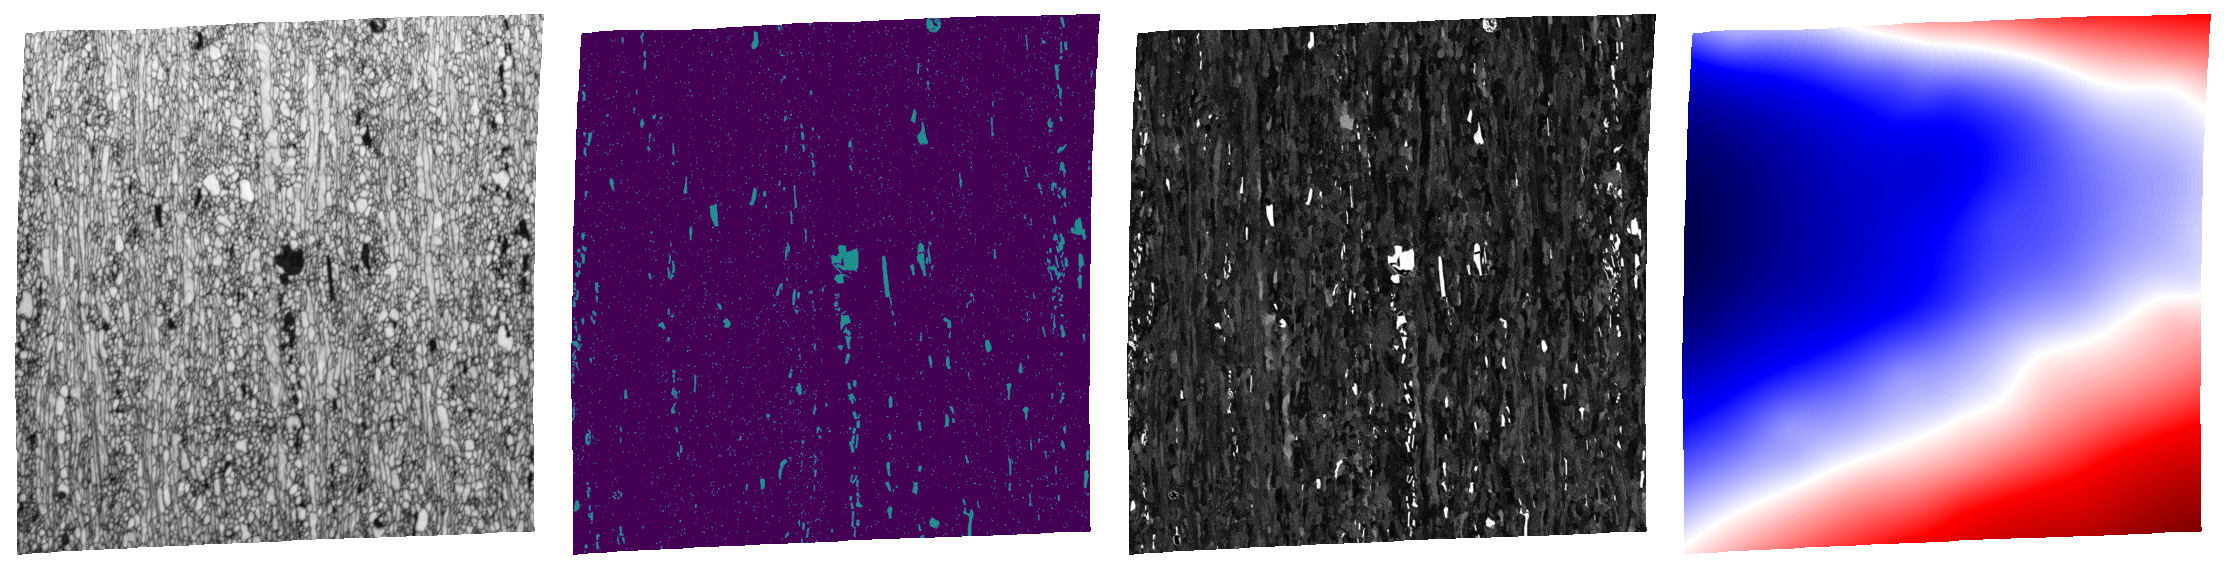

In [32]:
fig, ax = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(15, 5))
ax[0].imshow(xmap_refori2.get_map_data("scores"), cmap="gray")
ax[1].imshow(xmap_refori2.get_map_data("n_particles"))
ax[2].imshow(xmap_refori2.get_map_data("bse"), cmap="gray")
ax[3].imshow(xmap_refori2.get_map_data("r_shift"), cmap="seismic")
for a in ax:
    a.axis("off")
fig.tight_layout();

In [33]:
oio.save(os.path.join(dir_kp, "xmap_refori2.h5"), xmap_refori2, overwrite=True)
oio.save(
    os.path.join(dir_kp, "xmap_refori2.ang"),
    xmap_refori2,
    extra_prop=["n_particles", "n_pixels"],
    overwrite=True
)

Compare map areas before and after correction

In [34]:
# Shape of ROI
nominal_shape = np.array(xmap_refori.shape) * xmap_refori.dx
actual_shape = (
    xmap_refori2.y.max() - xmap_refori2.y.min(),
    xmap_refori2.x.max() - xmap_refori2.x.min()
)
print(
    "ROI\n---",
    "\nNominal (square):\t", np.round(nominal_shape, decimals=1), "um^2",
    "\nActual (non-square):\t", np.round(actual_shape, decimals=1), "um^2"
)

# Total area of scanned points
nominal_area = xmap_refori.size * xmap_refori.dx ** 2
actual_area = xmap_refori2.size * xmap_refori2.dx ** 2
print(
    "\nArea\n----",
    f"\nNominal:\t\t {nominal_area:.2f} um^2",
    f"\nActual:\t\t\t {actual_area:.2f} um^2",
    f"\nActual / nominal:\t {100 * actual_area / nominal_area:.1f}%",
)

ROI
--- 
Nominal (square):	 [91.9 91.9] um^2 
Actual (non-square):	 [93.7 91.6] um^2

Area
---- 
Nominal:		 8445.61 um^2 
Actual:			 8122.61 um^2 
Actual / nominal:	 96.2%


## Compare similarity of corrected EBSD map and BSE image

In [35]:
def norm_data(a):
    return (a - np.mean(a)) / np.std(a)


def ncc(a, b):
    return np.sum(norm_data(a) * norm_data(b)) / a.size


def draw_random_control_points(cp_bse, cp_ebsd, n):
    n_all = cp_bse.shape[0]
    keep_idx = np.random.choice(np.arange(n_all), size=n_all - n, replace=False)
    return cp_bse_scaled[keep_idx], cp_ebsd[keep_idx], keep_idx

Similarity with all CPs

In [36]:
ncc(ebsd_correct3[mask2], bse2[mask2])

0.36247850391394487

In [37]:
scale = step_size["ebsd"] / step_size["bse"]

out_shape = out_shapes[dset_no]
out_size = int(np.prod(out_shape))
rc_out = np.indices(out_shape, dtype=float).reshape((2, -1)).T
n_chunks = 100
chunk_size = int(np.ceil(out_size / n_chunks))

Remove CPs in steps and perform 30 trials per n removals (takes about 10 minutes with the given parameters)

In [38]:
subtract = np.arange(5, n_cps - 5, 5)
n_trials = 30

ncc_scores = np.zeros((len(subtract), n_trials))
n_cps_all = cp_ebsd.shape[0]
cps_keep_idx = np.zeros((len(subtract), n_trials, n_cps_all), dtype=int)

for i, sub in enumerate(subtract):
    delayed_list = []
    for trial in range(n_trials):
        cp_bse_scaled2, cp_ebsd2, keep_idx = draw_random_control_points(cp_bse_scaled, cp_ebsd, sub)
        cps_keep_idx[i, trial, :n_cps_all - sub] = keep_idx
        for idx in range(0, n_chunks * chunk_size, chunk_size):
            rc_chunk = rc_out[idx:idx + chunk_size]
            rc_in_part = dask.delayed(morphops.tps_warp)(X=cp_bse_scaled2, Y=cp_ebsd2, pts=rc_chunk)
            delayed_list.append(rc_in_part)

    with ProgressBar():
        rc_in_all = np.stack(dask.compute(*delayed_list)).reshape((n_trials, out_size, 2))

    for trial in trange(n_trials):
        rc_in = rc_in_all[trial]
        rc_in_1d, rc_in_2d, rc_out_1d, rc_out_2d = get_mapping_arrays(
            rc_in=rc_in, in_shape=ebsd.shape, out_shape=out_shape
        )
        
        ebsd_correct_i = map_in_image(ebsd, out_shape, rc_in_2d, rc_out_2d)
        ebsd_correct2_i = skt.rescale(ebsd_correct_i, scale)
        ebsd_correct3_i = ebsd_correct2_i[:bse.shape[0], :bse.shape[1]]
        
        mask_i = np.zeros(out_shape, dtype=bool)
        mask_i[rc_out_2d] = True
        mask2_i = skt.rescale(mask_i, scale).astype(bool)
        mask2_i = mask2_i[:bse.shape[0], :bse.shape[1]]

        ncc_scores[i, trial] = ncc(ebsd_correct3_i[mask2_i], bse[mask2_i])
    print(f"{sub}: ", ncc_scores[i].mean())

[########################################] | 100% Completed |  1min  2.1s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:19<00:00,  1.50it/s]


5:  0.36220580910276506
[########################################] | 100% Completed | 59.0s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.48it/s]


10:  0.36199129349084747
[########################################] | 100% Completed | 55.7s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.48it/s]


15:  0.36151476686382084
[########################################] | 100% Completed | 54.4s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.49it/s]


20:  0.36027721261442225
[########################################] | 100% Completed | 52.8s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.46it/s]


25:  0.3593276059932274
[########################################] | 100% Completed | 48.0s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:19<00:00,  1.52it/s]


30:  0.35832030027791756
[########################################] | 100% Completed | 46.1s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.49it/s]


35:  0.35668830693583975
[########################################] | 100% Completed | 37.9s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.50it/s]


40:  0.3546254876277684
[########################################] | 100% Completed | 26.3s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.47it/s]


45:  0.353234381976621
[########################################] | 100% Completed | 31.6s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.43it/s]


50:  0.3501064147359604
[########################################] | 100% Completed | 29.9s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.48it/s]


55:  0.3443043923791457
[########################################] | 100% Completed | 22.7s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.45it/s]


60:  0.3374837424775055
[########################################] | 100% Completed | 17.0s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.49it/s]


65:  0.3178814032969095
[########################################] | 100% Completed |  7.1s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.46it/s]


70:  0.3077360689667305
[########################################] | 100% Completed |  5.8s


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.48it/s]

75:  0.24003186962898718


Save results to file

In [39]:
np.save(os.path.join(dir_imreg, "cps_keep_idx"), cps_keep_idx)
np.save(os.path.join(dir_imreg, "ncc_scores"), ncc_scores)

Plot absolute decrease in $r$

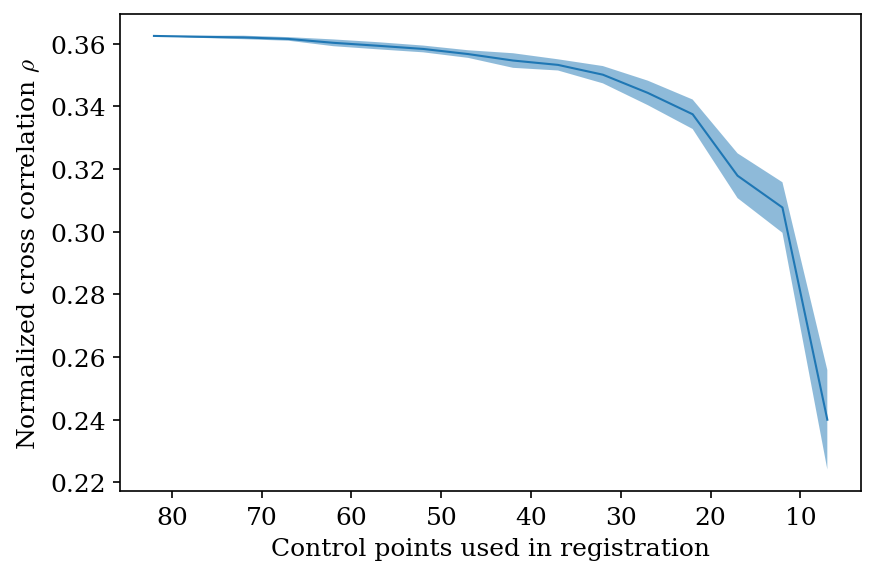

In [40]:
n_cps_used = n_cps_all - np.array(subtract)
ncc_scores_mean = ncc_scores.mean(axis=1)
conf_int = 1.96 * ncc_scores.std(axis=1) / np.sqrt(n_trials)

# Prepend all CPs
n_cps_used = np.append(n_cps_used[::-1], n_cps_all)[::-1]
ncc_scores_mean = np.append(ncc_scores_mean[::-1], ncc(ebsd_correct3[mask2], bse2[mask2]))[::-1]
conf_int = np.append(conf_int[::-1], 0)[::-1]

fig, ax = plt.subplots()
ax.plot(n_cps_used, ncc_scores_mean)
ax.fill_between(n_cps_used, y1=ncc_scores_mean - conf_int, y2=ncc_scores_mean + conf_int, alpha=0.5)
ax.invert_xaxis()
ax.set_xlabel("Control points used in registration")
ax.set_ylabel(r"Normalized cross correlation $\rho$")
fig.tight_layout()
fig.savefig(os.path.join(dir_imreg, "ncc_vs_n_cps.png"), **savefig_kw)

Plot relative increase in the difference of $r$

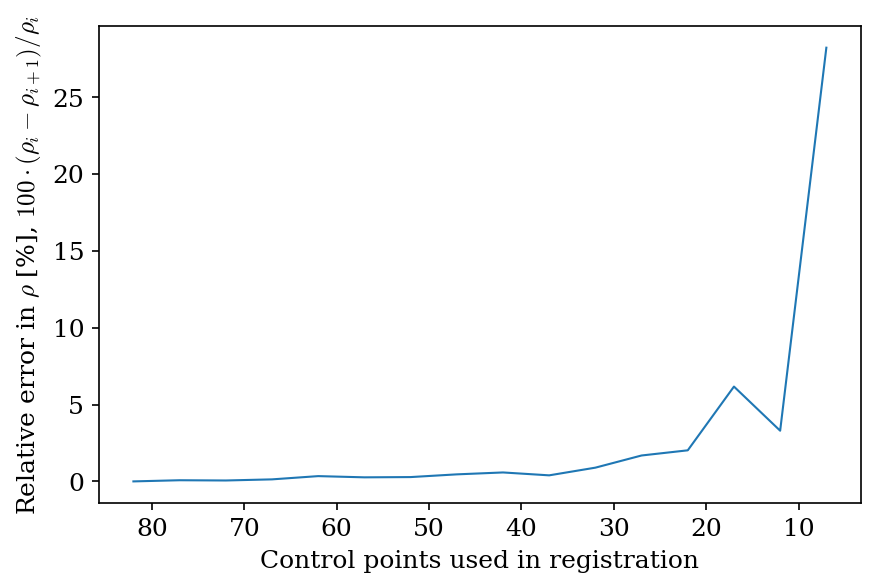

In [41]:
ncc_diff = np.append(np.diff(ncc_scores_mean[::-1]), 0)[::-1]
ncc_diff_rel = 100 * ncc_diff / ncc_scores_mean

fig, ax = plt.subplots()
ax.plot(n_cps_used, ncc_diff_rel)
ax.invert_xaxis()
ax.set_xlabel("Control points used in registration")
ax.set_ylabel(r"Relative error in $\rho$ [%], $100 \cdot (\rho_i - \rho_{i + 1}) / \rho_i$")
fig.tight_layout()
fig.savefig(os.path.join(dir_imreg, "ncc_error_vs_n_cps.png"), **savefig_kw)

### Similarity of corrected EBSD map and BSE image from all three data sets

In [42]:
ncc_scores_all = []
n_cps_dset = []
n_cps_kept = []
for i in range(1, 4):
    dir_imreg_i = os.path.join(dir_data, str(i), "imreg")
    ncc_scores_i = np.load(os.path.join(dir_imreg_i, "ncc_scores.npy"))
    ncc_scores_all.append(ncc_scores_i)

    # Get number of control points per dataset
    cpx_ebsd = np.loadtxt(
        os.path.join(dir_imreg_i, "cps_300c_cropped2_fused_cropped.csv"),
        skiprows=1,
        delimiter=",",
        usecols=(0,)
    )
    n_cps_dset.append(cpx_ebsd.size)

    n_cps_kept.append(np.arange(5, cpx_ebsd.size - 5, 5))

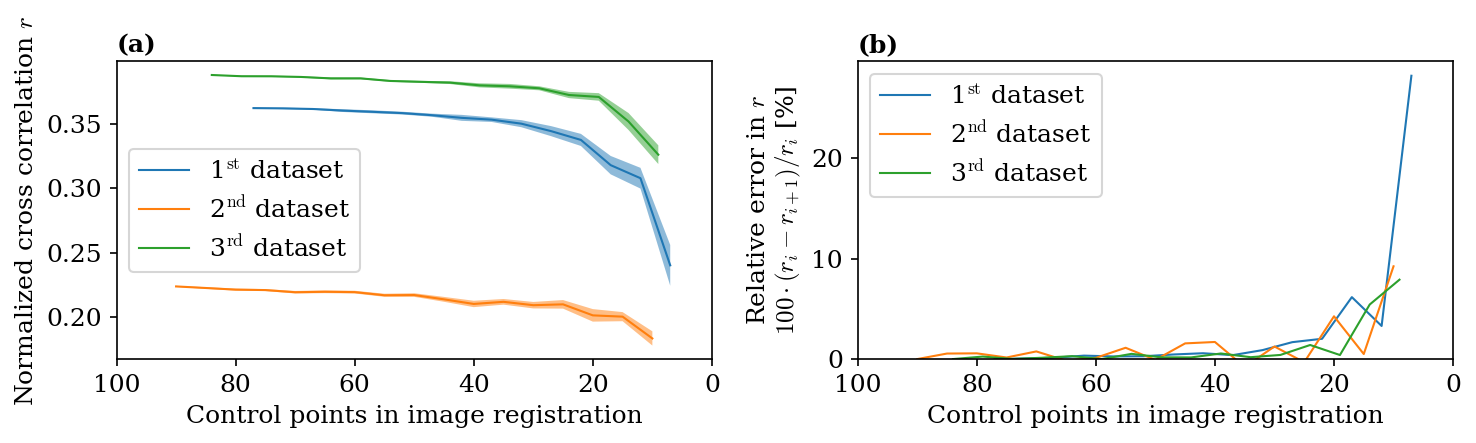

In [43]:
n_trials = ncc_scores_all[0].shape[1]

labels = ["1$^{\mathrm{st}}$", "2$^{\mathrm{nd}}$", "3$^{\mathrm{rd}}$"]

fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
for i in range(3):
    label_i = f"{labels[i]} dataset"
    n_cps_used_i = n_cps_dset[i] - n_cps_kept[i]
    ncc_scores_mean_i = ncc_scores_all[i].mean(axis=1)
    conf_int_i = 1.96 * ncc_scores_all[i].std(axis=1) / np.sqrt(n_trials)
    ax[0].plot(n_cps_used_i, ncc_scores_mean_i, label=label_i)
    ax[0].fill_between(
        n_cps_used_i, y1=ncc_scores_mean_i - conf_int_i,
        y2=ncc_scores_mean_i + conf_int_i,
        alpha=0.5
    )

    ncc_diff_i = np.append(np.diff(ncc_scores_mean_i[::-1]), 0)[::-1]
    ncc_diff_rel_i = 100 * ncc_diff_i / ncc_scores_mean_i
    ax[1].plot(n_cps_used_i, ncc_diff_rel_i, label=label_i)

ax[0].invert_xaxis()
ax[1].invert_xaxis()
ax[0].set_xlim(100, 0)
ax[1].set_xlim(100, 0)
ax[1].set_ylim(0)
ax[0].set_xlabel("Control points in image registration")
ax[1].set_xlabel("Control points in image registration")
ax[0].set_ylabel(r"Normalized cross correlation $r$")
ax[1].set_ylabel(r"Relative error in $r$" + "\n" + r"$100 \cdot (r_i - r_{i + 1}) / r_i$ [%]")
ax[0].text(0, 1.03, "(a)", fontweight="bold", transform=ax[0].transAxes) 
ax[1].text(0, 1.03, "(b)", fontweight="bold", transform=ax[1].transAxes) 
ax[0].legend()
ax[1].legend()
fig.tight_layout()

fig.savefig(
    os.path.join(dir_suppl, "registration_similarity", "registration_similarity.pdf"),
    **savefig_kw
)